In [1]:
import pandas as pd
import numpy as np
import sys
import os
import nltk
import gensim
import csv
import re
import pickle as pkl
import string

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from spacy.lang.nl import Dutch
import nl_bertje

from collections import Counter

import plotly

from platform import python_version

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

In [2]:
python_version()

'3.6.12'

# Catboost

## Data preparation

In [3]:

#data = pd.read_excel('Annotation_sample_OB_ingevuld_Oele.xlsm', engine='openpyxl')
data = pd.read_csv('DatasetSA_classification.csv', sep=';')
data = data[['FileName', 'FileCode', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
data = data.dropna(subset=['SA Label'])
data = data.drop_duplicates(subset= 'cleaned_text')
data.shape
#vec = TfidfVectorizer()
#vectors = vec.fit_transform(data['cleaned_text']).todense()
#data['text_vectors'] = 

(2119, 7)

In [4]:
train_data, valtest_data = train_test_split(data[['FileCode', 'cleaned_text', 'SA Label']], stratify=data['SA Label'], test_size=0.2)
val_data, test_data = train_test_split(valtest_data[['FileCode', 'cleaned_text', 'SA Label']], stratify=valtest_data['SA Label'], test_size=0.5)

In [5]:
train_texts = train_data['cleaned_text'].tolist()
train_labels = train_data['SA Label'].tolist()
valid_texts = val_data['cleaned_text'].tolist()
valid_labels = val_data['SA Label'].tolist()
test_texts = test_data['cleaned_text'].tolist()
test_labels = test_data['SA Label'].tolist()



In [6]:
len(train_data)

1695

In [7]:
len(val_data)

212

In [8]:
# apply pooling
X_train = pd.DataFrame(train_texts, columns=['text'])
y_train = train_data['SA Label']

X_valid = pd.DataFrame(valid_texts, columns=['text'])
y_valid = val_data['SA Label']


X_test  = pd.DataFrame(test_texts, columns=['text'])
y_test  = test_data['SA Label']

train_data_pool = Pool(X_train, y_train, text_features=['text'])
valid_data_pool = Pool(X_valid, y_valid, text_features=['text'])
test_data_pool = Pool(X_test, X_test, text_features=['text'])


## Set up model and evaluate on training and validation data

In [9]:
quick_model = CatBoostClassifier(iterations=100
                          , depth=1
                          , learning_rate=None
                          , objective= 'MultiClass'
                          , loss_function='MultiClass'
                          , eval_metric= 'MultiClass'
                          , verbose=False
                          , auto_class_weights='Balanced')



quick_model.fit(train_data_pool)

results_train = quick_model.predict(X_train)
print("TRAIN:")
print(classification_report(y_train.tolist(),results_train.tolist()))
print()

results_val = quick_model.predict(X_valid)
print("VALIDATION:")
print(classification_report(y_valid.tolist(),results_val.tolist()))
print()




TRAIN:
                        precision    recall  f1-score   support

            commissive       0.53      0.89      0.66       137
           declarative       0.58      0.84      0.68       142
 directive/instructive       0.77      0.88      0.82       390
informative/persuasive       0.93      0.62      0.74       900
         miscellaneous       0.55      0.90      0.68       126

              accuracy                           0.74      1695
             macro avg       0.67      0.83      0.72      1695
          weighted avg       0.80      0.74      0.75      1695


VALIDATION:
                        precision    recall  f1-score   support

            commissive       0.43      0.71      0.53        17
           declarative       0.43      0.67      0.52        18
 directive/instructive       0.74      0.81      0.77        48
informative/persuasive       0.79      0.55      0.65       113
         miscellaneous       0.40      0.62      0.49        16

              a

In [10]:
quick_model.get_all_params()


{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'use_best_model': False,
 'class_names': ['commissive',
  'declarative',
  'directive/instructive',
  'informative/persuasive',
  'miscellaneous'],
 'random_seed': 0,
 'depth': 1,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [6.569343090057373,
  6.3380279541015625,
  2.307692289352417,
  1,
  7.142857074737549],
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'Balanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,


## Evaluation on development set

[[62 12 12 15 12]
 [ 5 39  2  1  1]
 [ 3  2 12  0  0]
 [ 3  0  1 12  2]
 [ 5  0  1  0 10]]


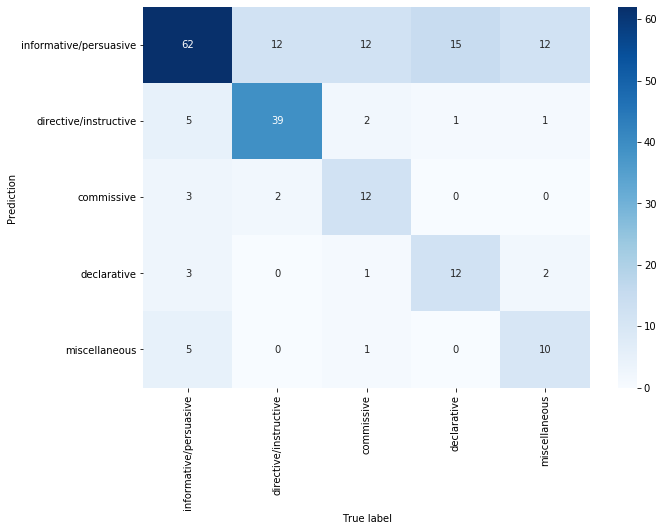

In [11]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(y_valid, results_val, normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plot.figure.savefig('pics/Catboost_val.png')

In [12]:
results_test = quick_model.predict(X_test)
print("VALID:")
print(classification_report(y_valid.tolist(),results_val.tolist()))
print()

VALID:
                        precision    recall  f1-score   support

            commissive       0.43      0.71      0.53        17
           declarative       0.43      0.67      0.52        18
 directive/instructive       0.74      0.81      0.77        48
informative/persuasive       0.79      0.55      0.65       113
         miscellaneous       0.40      0.62      0.49        16

              accuracy                           0.64       212
             macro avg       0.56      0.67      0.59       212
          weighted avg       0.69      0.64      0.64       212




## Evaluation on test set

[[60 16 14 13  9]
 [ 5 35  6  1  2]
 [ 3  1 12  1  0]
 [ 2  1  3 11  1]
 [ 3  0  0  0 13]]


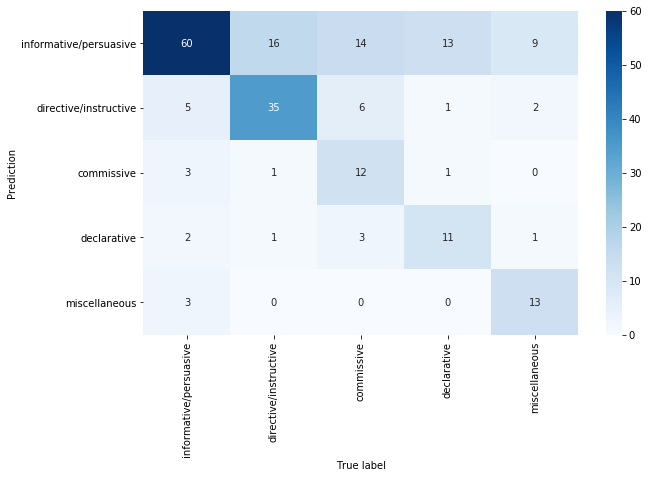

In [13]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(y_test, results_test, normalize=None, labels=labels)

print(cm)

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/Catboost_test.png')

In [14]:
results_test = quick_model.predict(X_test)
print("TEST:")
print(classification_report(y_test.tolist(),results_test.tolist()))
print()


TEST:
                        precision    recall  f1-score   support

            commissive       0.34      0.71      0.46        17
           declarative       0.42      0.61      0.50        18
 directive/instructive       0.66      0.71      0.69        49
informative/persuasive       0.82      0.54      0.65       112
         miscellaneous       0.52      0.81      0.63        16

              accuracy                           0.62       212
             macro avg       0.55      0.68      0.59       212
          weighted avg       0.69      0.62      0.63       212




### Error analysis

In [24]:
print(Counter(y_test))
gold = y_test
print(Counter(gold))
print(len(gold))
print(len(X_test))
print(len(results_test))
X_test[:3]

Counter({'informative/persuasive': 112, 'directive/instructive': 49, 'declarative': 18, 'commissive': 17, 'miscellaneous': 16})
Counter({'informative/persuasive': 112, 'directive/instructive': 49, 'declarative': 18, 'commissive': 17, 'miscellaneous': 16})
212
212
212


,text
0,NL ob_nummer uw naam en adres als fiscaal vert...
1,Als u het niet eens bent met de vastgestelde i...
2,naam De Heer Mevrouw naam_beslag adres adres...


In [16]:
error_analysis = pd.DataFrame()
error_analysis['cleaned_text'] = X_test['text']
error_analysis['gold_label'] = y_test.to_list()
error_analysis['prediction'] = results_test

error_analysis.shape

(212, 3)

In [23]:
counter = 0
error_counter = 0
values_list = []
values_counter = 0
zero_dict_counter = 0
for row in error_analysis.values:
    counter += 1
    if row[-1] != row[-2]:
        error_counter += 1
        #print("Sentence: ", row[0])
        ##print("gold label: ", row[-2], '-- predicted label: ', row[-1])
        print()
    #if row[-1] != row[-2]:
        #if row[-1] == 'declarative':
            #print(row)
        
print("FINAL COUNTS")        
print("counter: ", counter)
print("errors: ", error_counter)



















































































FINAL COUNTS
counter:  212
errors:  81


## Performance per domain

In [18]:
#Performance per domein
def cm_subset(df, true, pred, label, column):
    df["pred"] = pred
    df = df[df[column] == label]
    true = df["SA Label"].tolist()
    pred = df["pred"].tolist()
    
    print(classification_report(true,pred))
    
    labels=['informative/persuasive','directive/instructive', 'commissive', 'miscellaneous'] ##add declarative later
    x = labels
    y = labels

    cm = confusion_matrix(true, pred, normalize=None, labels=labels)
    #z_text = [[str(y) for y in x] for x in cm]

    #print(cm)
    #fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
    #fig.show("notebook")

    plt.figure(figsize = (10,7))
    plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues')
    plot.set_xlabel("True label")
    plot.set_ylabel("Prediction")
    plot
    


## Development set

                        precision    recall  f1-score   support

            commissive       0.29      0.50      0.36         4
           declarative       0.36      0.50      0.42        10
 directive/instructive       0.86      0.67      0.75         9
informative/persuasive       0.75      0.56      0.64        27
         miscellaneous       0.25      0.50      0.33         2

              accuracy                           0.56        52
             macro avg       0.50      0.54      0.50        52
          weighted avg       0.64      0.56      0.58        52



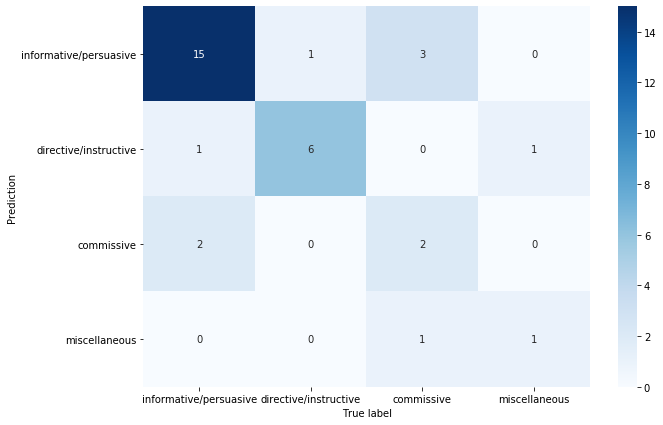

In [19]:
cm_subset(val_data, y_valid, results_val, 'OB', 'FileCode')

                        precision    recall  f1-score   support

            commissive       0.47      0.88      0.61         8
           declarative       0.62      0.83      0.71         6
 directive/instructive       0.77      0.82      0.79        28
informative/persuasive       0.78      0.57      0.66        68
         miscellaneous       0.40      0.62      0.48        13

              accuracy                           0.67       123
             macro avg       0.61      0.74      0.65       123
          weighted avg       0.71      0.67      0.67       123



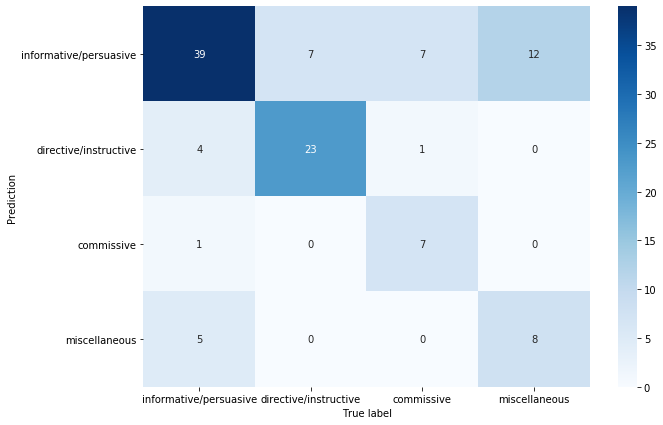

In [20]:
cm_subset(val_data, y_valid, results_val, 'IV', 'FileCode')

                        precision    recall  f1-score   support

            commissive       0.50      0.60      0.55         5
           declarative       0.33      1.00      0.50         2
 directive/instructive       0.62      0.91      0.74        11
informative/persuasive       1.00      0.44      0.62        18
         miscellaneous       1.00      1.00      1.00         1

              accuracy                           0.65        37
             macro avg       0.69      0.79      0.68        37
          weighted avg       0.78      0.65      0.65        37



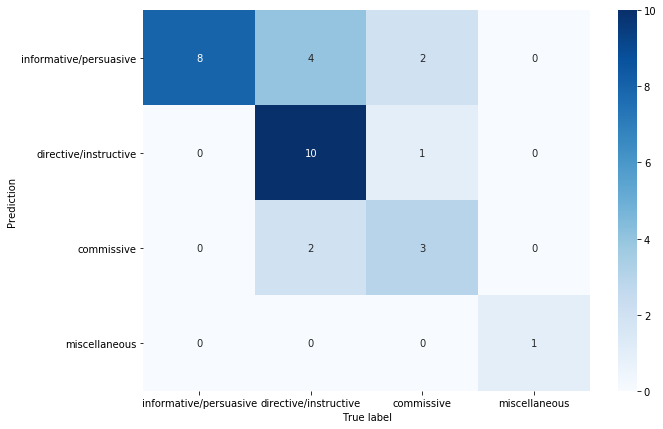

In [21]:
cm_subset(val_data, y_valid, results_val, 'INL', 'FileCode')

## Test set

In [ ]:
cm_subset(test_data, y_test, results_test, 'OB', 'FileCode')